In [10]:
import graphlab as gl
import graphlab.numpy
from datacleaner import autoclean
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load some house sales data

In [11]:
# clean up the training data
my_data = pd.read_csv('train.csv', sep=',')
my_clean_data = autoclean(my_data)
my_data.to_csv('my_clean_train.csv', sep=',', index=False)
# clean up the test data
my_testdata = pd.read_csv('test.csv', sep=',')
my_clean_testdata = autoclean(my_testdata)
my_testdata.to_csv('my_clean_testdata.csv', sep=',', index=False)
predict_sales = gl.SFrame(my_testdata)

# Select only the columns which has correlations with SalePrice
It was found that the correlation > 0.3 performs the best and produce the best predictions

In [12]:
correlation = my_clean_data.corr()["SalePrice"]
print correlation

my_columns = np.sort(np.where(abs(correlation) > 0.3))
myFilteredData = my_clean_data.iloc[:, my_columns.tolist()[0]]
mynewcolumns = my_clean_data.iloc[:0, my_columns.tolist()[0]]
column_string = map(str, mynewcolumns)
print ''
print 'Top'
print np.count_nonzero(column_string)
print 'Highly Correlated Columns'
print column_string

features = myFilteredData.columns.tolist()

Id                 -0.021917
MSSubClass         -0.084284
MSZoning           -0.166872
LotFrontage         0.334771
LotArea             0.263843
Street              0.041036
Alley              -0.027655
LotShape           -0.255580
LandContour         0.015453
Utilities          -0.014314
LotConfig          -0.067396
LandSlope           0.051152
Neighborhood        0.210851
LiveabilityScale    0.215784
Income2010          0.484363
Condition1          0.091155
Condition2          0.007513
BldgType           -0.085591
HouseStyle          0.180163
OverallQual         0.790982
OverallCond        -0.077856
YearBuilt           0.522897
YearRemodAdd        0.507101
RoofStyle           0.222405
RoofMatl            0.132383
Exterior1st         0.103551
Exterior2nd         0.103766
MasVnrType          0.018216
MasVnrArea          0.472614
ExterQual          -0.636884
                      ...   
BedroomAbvGr        0.168213
KitchenAbvGr       -0.135907
KitchenQual        -0.589189
TotRmsAbvGrd  

# Instead of removing all outliers, we can replace the ourliers with NaN and then perform the auto-cleaning again to replace the NaN values with mean
This produces a better result than removing the rows completely if outliers are detected


In [8]:
my_dirtydata =  myFilteredData[np.abs(myFilteredData-myFilteredData.mean())<=(3*myFilteredData.std())]
myFilteredData_without_outliers = autoclean(my_dirtydata)
print myFilteredData_without_outliers

      LotFrontage  Income2010  OverallQual  YearBuilt  YearRemodAdd  \
0            65.0     88958.0          7.0     2003.0          2003   
1            80.0     96250.0          6.0     1976.0          1976   
2            68.0     88958.0          7.0     2001.0          2002   
3            60.0     65096.0          7.0     1915.0          1970   
4            84.0     96250.0          8.0     2000.0          2000   
5            85.0     75625.0          5.0     1993.0          1995   
6            75.0     96250.0          8.0     2004.0          2005   
7            69.0     77308.0          7.0     1973.0          1973   
8            51.0     65096.0          7.0     1931.0          1950   
9            50.0     76522.0          5.0     1939.0          1950   
10           70.0     76522.0          5.0     1965.0          1965   
11           85.0     96250.0          9.0     2005.0          2006   
12           69.0     76522.0          5.0     1962.0          1962   
13    

In [9]:
#from scipy import stats
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
#df = pd.DataFrame(myFilteredData, columns=column_string)
#myFilteredData_without_outliers = df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
#print myFilteredData_without_outliers
#this is the filtered and outliers removed data
sales = gl.SFrame(myFilteredData_without_outliers)
# this is the original data without removing outliers and non-correlated columns
sales_ori = gl.SFrame(my_clean_data)

# Test from Nico

In [139]:
# Store all the feature labels of train_df into a list; remove the SalePrice.
features = myFilteredData_without_outliers.columns.tolist()
features.remove('SalePrice')

# Generate the training set. Set random_state to be able to replicate results.
# Our train data will contain 80% of train_df.
train = myFilteredData_without_outliers.sample(frac=0.8, random_state=1)

# Select anything not in the training set (20%) and put it in the validation set.
validation = myFilteredData_without_outliers.loc[~myFilteredData_without_outliers.index.isin(train.index)]

print "train (80%):"
print train.shape
print "validation (20%):"
print validation.shape

train (80%):
(1168, 27)
validation (20%):
(292, 27)


# Split 80% training data and 20% validation data

In [177]:
train_data,test_data = sales.random_split(.8,seed=0)
train_data_ori,test_data_ori = sales_ori.random_split(.8,seed=0)

print "train (80%):"
print train_data.shape
print "validation (20%):"
print test_data.shape

train (80%):
(1157, 27)
validation (20%):
(303, 27)


# Build the regression model
This first model uses only the Ground Living Area as the feature as it has the highest correlation score

In [178]:
GrLivArea_model = gl.linear_regression.create(train_data, target='SalePrice', features=['GrLivArea'])

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 1101

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.001001     | 207810.995619      | 236810.995619        | 49435.120376  | 64383.183613    |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

# Evaluate the simple model (one feature)

This shows the mean SalePrice

In [142]:
print test_data['SalePrice'].mean()

176555.706271


"Max_error" means the outliers (USD500k is the outlier) and RMSE is the "Root Mean Square Error"

In [143]:
print GrLivArea_model.evaluate(test_data)

{'max_error': 222217.04188520057, 'rmse': 49896.418565134256}


In [144]:
import matplotlib.pyplot as plt
%matplotlib inline

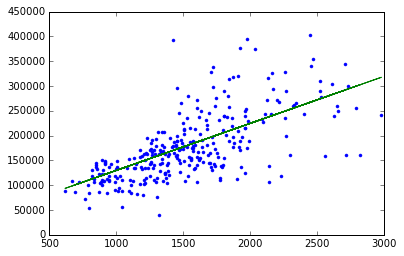

In [182]:
plt.plot(test_data['GrLivArea'], test_data['SalePrice'], '.', test_data['GrLivArea'], GrLivArea_model.predict(test_data), '-')

In [181]:
GrLivArea_model.get('coefficients')

name,index,value,stderr
(intercept),None,35092.5452584,4956.98509929
GrLivArea,None,94.8464691779,3.20041183547


The summary from table above is the value of y intercept is USD23490 and average price for GrLivArea is USD100 per sqf

# Create a new multi features model (Original - with 80 features)

In [147]:
my_features_model_ori = gl.linear_regression.create(train_data_ori,target='SalePrice')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 1107

Number of features          : 82

Number of unpacked features : 82

Number of coefficients    : 83

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.019960     | 308383.027311      | 104960.604518        | 30491.202651  | 26519.705122    |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

# Random Forest Regressor

In [148]:
# Initialize the model.
# Note: The parameters given here are not really optimized yet. Apparantly, n_estimator
#       is the one we should pay the most attention to. For details see:
#       http://scikit-learn.org/stable/modules/ensemble.html#parameters

random_forest_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=1)

random_forest_model.fit(train[features], train['SalePrice'])

# Make predictions for our validation set.
predictions = random_forest_model.predict(validation[features])

# Compute the error.
print 'Mean Squared Error:', mean_squared_error(predictions, validation['SalePrice'])

Mean Squared Error: 827438158.318


In [149]:
# TO DO: Optimize parameters (see comments in the codeblock above).
random_forest_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=1)
random_forest_model.fit(train[features], train['SalePrice'])
predictions = random_forest_model.predict(my_clean_testdata[features])

# Create a new multi features model (After removing non-correlated columns)

In [150]:
my_features_model = gl.linear_regression.create(train_data,target='SalePrice')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 1102

Number of features          : 26

Number of unpacked features : 26

Number of coefficients    : 27

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.009006     | 179847.146106      | 142851.323486        | 30727.154762  | 32222.165919    |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

In [151]:
print column_string

['LotFrontage', 'Income2010', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtFinSF1', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']


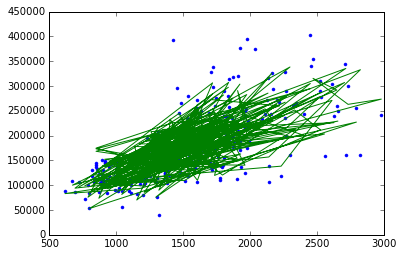

In [183]:
plt.plot(test_data['GrLivArea'], test_data['SalePrice'], '.', test_data['GrLivArea'], my_features_model.predict(test_data), '-')

In [153]:
GrLivArea_model.get('coefficients')

name,index,value,stderr
(intercept),None,33881.3194008,5107.30552582
GrLivArea,None,95.7728250275,3.28193866568


In [154]:
my_features_model.get('coefficients')

name,index,value,stderr
(intercept),None,-391389.235603,173995.104349
LotFrontage,None,172.994160704,60.3714696384
Income2010,None,0.356033957472,0.121947358347
OverallQual,None,9739.73569269,1213.4192534
YearBuilt,None,88.2046998795,69.2646141189
YearRemodAdd,None,278.568455634,65.8125569155
MasVnrArea,None,27.1703006717,7.80540408351
ExterQual,None,-6663.54308929,2378.59895655
Foundation,None,3271.61398763,2050.27083679
BsmtQual,None,-4286.24080479,1524.27036816


# Result before removing outliers
{'max_error': 263715.68381302676, 'rmse': 53423.71497179019}
{'max_error': 200848.92346621933, 'rmse': 34190.02483489307}

# Result After replacing outliers with mean value
Maximum error reduced to 175653 {'max_error': 175653.45332768967, 'rmse': 33734.99971664569}

In [155]:
print 'Result with only one feature'
print GrLivArea_model.evaluate(test_data)
print ''
print 'Result before selecting correlated columns and replacing outliers with mean'
#result before selecting correlated columns and removing outliers
print my_features_model_ori.evaluate(test_data)
print ''
print 'Result after selecting correlated columns and replacing outliers with mean'
#result after selecting correlated columns
print my_features_model.evaluate(test_data)

Result with only one feature
{'max_error': 222217.04188520057, 'rmse': 49896.418565134256}

Result before selecting correlated columns and replacing outliers with mean
{'max_error': 197663.35801424633, 'rmse': 37877.64801796358}

Result after selecting correlated columns and replacing outliers with mean
{'max_error': 176804.02859922964, 'rmse': 33648.42087399737}


# Apply learned models to predict  prices of house

In [156]:
house1 = gl.SFrame(predict_sales)
X = house1.select_columns(['Id'])
# convert this to SArray
Y = X["Id"]

In [157]:
# Result from Random Forest Regressor

round_up = np.around(predictions, decimals=1, out=None)

sf = gl.SFrame({'Id':Y, 'SalePrice':round_up})
K =sf["Id","SalePrice"]
print K

+------+-----------+
|  Id  | SalePrice |
+------+-----------+
| 1461 |  123733.3 |
| 1462 |  149617.0 |
| 1463 |  185949.1 |
| 1464 |  184285.3 |
| 1465 |  203047.6 |
| 1466 |  182560.8 |
| 1467 |  166300.0 |
| 1468 |  173960.2 |
| 1469 |  189169.1 |
| 1470 |  128225.8 |
+------+-----------+
[1459 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [179]:
# Result from Linear Regression

my_results = my_features_model.predict(house1)
#print type(my_results)
round_up = np.around(my_results, decimals=1, out=None)

sf = gl.SFrame({'Id':Y, 'SalePrice':round_up})
Z =sf["Id","SalePrice"]
print Z

+------+-----------+
|  Id  | SalePrice |
+------+-----------+
| 1461 |  123914.9 |
| 1462 |  167098.6 |
| 1463 |  187493.0 |
| 1464 |  197470.3 |
| 1465 |  195233.4 |
| 1466 |  179987.3 |
| 1467 |  186546.1 |
| 1468 |  164796.3 |
| 1469 |  203158.3 |
| 1470 |  123365.6 |
+------+-----------+
[1459 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


# Copy the result to a new csv file
The kaggel competition result shows 0.16879 score for Linear Regression
The kaggel competition result shows 0.17790 score for Random Forest Regressor

In [77]:
my_result = Z.save('predicted_houseprice.csv', format='csv')

In [133]:
#my_result = K.save('predicted_houseprice.csv', format='csv')